In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from brukeropusreader import read_file
import numpy as np
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import warnings
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle
warnings.filterwarnings('ignore')  # Ignore all warnings

In [3]:

# Chemins vers vos dossiers
folder_path_oe = 'OE tissue'
folder_path_re = 'RE tissue'
folder_path_trachea = 'Trachea tissue'

In [4]:
# Fonction pour lister les fichiers dans un dossier
def list_files(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

# Lister les fichiers dans chaque dossier
files_re = list_files(folder_path_re)
files_oe = list_files(folder_path_oe)
files_trachea = list_files(folder_path_trachea)

# Displaying file names and their count
print("RE Folder:")
print(f"Number of files: {len(files_re)}")
print("Files:", files_re)

print("\nOE Folder:")
print(f"Number of files: {len(files_oe)}")
print("Files:", files_oe)

print("\nTrachea Folder:")
print(f"Number of files: {len(files_trachea)}")
print("Files:", files_trachea)

RE Folder:
Number of files: 159
Files: ['19022024 RE 5.0000', '20240318 RE B2.0000', '20240318 RE B3.0003', '20240415 C2 RE.0003', '20240311 RE 3.0003', '20240311 RE 2.0003', '20240304 RE 4.0004', '20240408 C2 RE.0004', '20240318 RE B5.0000', '19022024 RE 1.0000', '19022024 RE 4.0000', '20240304 RE 3.0004', '20240311 RE 1.0005', '20240311 RE 5.0001', '19022024 RE 2.0000', '20240318 RE B3.0004', '20240311 RE 1.0008', '20240408 C4 RE.0003', '20240415 C4 RE.0003', '20240415 C1 RE.0000', '19022024 RE 4.0001', '20240318 RE B2.0001', '19022024 RE 3.0004', '20240304 RE 2.0004', '19022024 RE 1.0003', '20240304 RE 1.0003', '20240311 RE 3.0002', '19022024 RE 2.0004', '20240311 RE 5.0003', '20240311 RE 4.0004', '19022024 RE 4.0003', '20240415 C3 RE.0001', '20240408 C3 RE.0002', '20240304 RE 3.0000', '20240408 C5 RE.0001', '20240415 C3 RE.0000', '20240311 RE 1.0006', '20240415 C1 RE.0002', '20240408 C2 RE.0000', '20240311 RE 1.0001', '20240318 RE B4.0004', '20240311 RE 1.0007', '20240318 RE B1.000

In [5]:
# Définir l'ensemble commun de nombres d'onde
start_wavenumber = 5000  # Le nombre d'onde de départ
end_wavenumber = 400  # Le nombre d'onde de fin
resolution = 1  # La résolution en cm⁻¹

# Générer l'ensemble commun de nombres d'onde
common_wavenumbers = np.arange(start_wavenumber, end_wavenumber - resolution, -resolution)

# Vérifiez la première et dernière valeurs ainsi que la taille de l'ensemble pour s'assurer qu'il correspond à vos attentes
print("Premier nombre d'onde :", common_wavenumbers[0])
print("Dernier nombre d'onde :", common_wavenumbers[-1])
print("Nombre total de points :", len(common_wavenumbers))

Premier nombre d'onde : 5000
Dernier nombre d'onde : 400
Nombre total de points : 4601


In [6]:
def get_wavenumbers(file_path):
    opus_data = read_file(file_path)
    # Supposons que les nombres d'onde sont stockés dans une clé 'WN' dans les données retournées
    # Extraire le nombre de points, le nombre d'onde de début et de fin
    num_points = len(opus_data['AB'])
    start_wn = opus_data['AB Data Parameter']['FXV']
    end_wn = opus_data['AB Data Parameter']['LXV']
# Générer la liste des nombres d'onde
    wavenumbers = np.linspace(start_wn, end_wn, num_points)
    
    return wavenumbers

In [7]:
def get_spectral_data(file_path):
    """
    Extracts spectral data (e.g., absorbance values) from a file.

    Parameters:
    - file_path: The path to the Bruker file.

    Returns:
    - A numpy array containing the spectral data.
    """
    opus_data = read_file(file_path)
    # Assuming the spectral data is stored in the 'AB' key
    spectral_data = opus_data['AB']
    return spectral_data

# You may need to adjust the `read_file` function to return the entire opus_data dictionary.


In [8]:
def interpolate_to_common_wavenumbers(file_path, common_wavenumbers):
    """
    Interpolates the spectral data from a file to a common set of wavenumbers.
    
    Parameters:
    - file_path: The path to the file.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of the interpolated spectral data.
    """
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    interpolation_func = interp1d(original_wavenumbers, original_data, kind='linear', fill_value="extrapolate")
    interpolated_data = interpolation_func(common_wavenumbers)
    return interpolated_data

In [9]:
def z_score_normalize(data):
    """
    Normalizes a data array using Z-score normalization.
    
    Parameters:
    - data: A numpy array of spectral data.
    
    Returns:
    - The Z-score normalized spectral data.
    """
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = (data - mean) / std_dev
    return normalized_data

In [10]:
def process_directory(folder_path, common_wavenumbers):
    """
    Processes all files in a directory, interpolating and normalizing their spectral data.
    
    Parameters:
    - folder_path: The path to the directory.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of all the normalized spectral data from the directory.
    """
    normalized_data_list = []
    files = list_files(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)
        normalized_data = z_score_normalize(data)
        normalized_data_list.append(normalized_data)
    return np.array(normalized_data_list)

In [11]:
# Process directories
data_oe = process_directory('OE tissue', common_wavenumbers)
data_re = process_directory('RE tissue', common_wavenumbers)
data_trachea = process_directory('Trachea tissue', common_wavenumbers)

In [12]:
print(data_oe)

[[-0.82329514 -1.03620166 -0.91845662 ...  0.0634433   0.20625885
   0.19267305]
 [-0.66599232 -0.90158994 -0.88844313 ...  0.17364294  0.48562095
  -0.13049977]
 [-0.55731009 -0.75168351 -0.99050443 ...  0.25779538  0.26138407
   0.50113961]
 ...
 [-0.66380361 -0.89185486 -0.90663467 ...  0.44515549  0.31741038
  -0.25770352]
 [-0.97341109 -0.91401882 -0.9615577  ...  0.48653366  0.24188255
   0.36834625]
 [-0.7340351  -0.77134432 -0.84544008 ...  0.20214604  0.62021413
  -0.22689326]]


In [13]:
# Vérifier si la liste des fichiers n'est pas vide
if files_trachea:
    first_file_trachea = files_trachea[0]
    print("Le premier fichier dans le dossier 'Trachea tissue' est:", first_file_trachea)
else:
    print("Aucun fichier trouvé dans le dossier.")

Le premier fichier dans le dossier 'Trachea tissue' est: 20240311 TE 5.0004


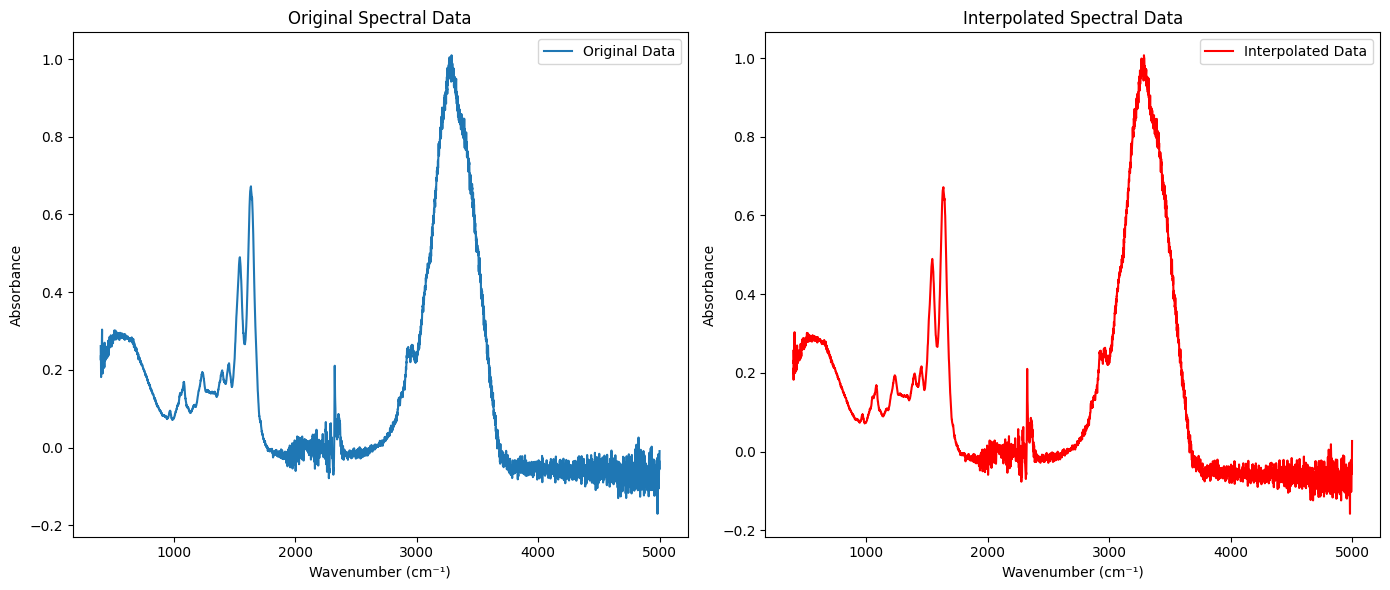

In [14]:
def plot_original_vs_interpolated(file_path, common_wavenumbers):
    # Obtenir les données spectrales et les nombres d'onde originaux
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    
    # Interpolation des données aux nombres d'onde communs
    interpolated_data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)

    # Tracer les données originales
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, 1ère subplot
    plt.plot(original_wavenumbers, original_data, label='Original Data')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Absorbance')
    plt.title('Original Spectral Data')
    plt.legend()

    # Tracer les données interpolées
    plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, 2ème subplot
    plt.plot(common_wavenumbers, interpolated_data, label='Interpolated Data', color='red')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Absorbance')
    plt.title('Interpolated Spectral Data')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Exemple d'utilisation sur un fichier spécifique
# Chemin complet du premier fichier
first_file_path = os.path.join(folder_path_trachea, first_file_trachea)

# Utilisation du fichier pour tracer les données originales et interpolées
plot_original_vs_interpolated(first_file_path, common_wavenumbers)

In [15]:
def print_wavenumber_range(file_path, common_wavenumbers):
    # Extraire les nombres d'onde originaux
    original_wavenumbers = get_wavenumbers(file_path)
    
    # Afficher la plage des nombres d'onde originaux
    print("Plage des nombres d'onde originaux:")
    print(" - Min:", np.min(original_wavenumbers))
    print(" - Max:", np.max(original_wavenumbers))
    
    # Afficher la plage des nombres d'onde interpolés
    print("Plage des nombres d'onde interpolés:")
    print(" - Min:", np.min(common_wavenumbers))
    print(" - Max:", np.max(common_wavenumbers))

# Utilisation du premier fichier du dossier "Trachea tissue"
folder_path_trachea = 'Trachea tissue'
files_trachea = list_files(folder_path_trachea)

if files_trachea:
    first_file_trachea = files_trachea[0]
    first_file_path = os.path.join(folder_path_trachea, first_file_trachea)
    print_wavenumber_range(first_file_path, common_wavenumbers)
else:
    print("Aucun fichier trouvé dans le dossier.")

Plage des nombres d'onde originaux:
 - Min: 399.9009272456169
 - Max: 4999.296694397926
Plage des nombres d'onde interpolés:
 - Min: 400
 - Max: 5000


In [16]:
# Fonction pour filtrer les nombres d'onde dans deux plages spécifiques et les concaténer
def filter_and_concatenate_wavenumbers(data, wavenumbers, ranges):
    filtered_data_list = []
    filtered_wavenumbers_list = []
    
    for min_w, max_w in ranges:
        indices = np.where((wavenumbers >= min_w) & (wavenumbers <= max_w))[0]
        if len(indices) == 0:
            print(f"Aucun indice trouvé pour la plage {min_w}-{max_w}")
            continue
        print(f"Indices trouvés pour la plage {min_w}-{max_w}: {indices}")
        filtered_data_list.append(data[:, indices])
        filtered_wavenumbers_list.append(wavenumbers[indices])
    
    if not filtered_data_list:
        raise ValueError("Aucun indice valide trouvé dans les plages spécifiées.")
    
    concatenated_data = np.concatenate(filtered_data_list, axis=1)
    concatenated_wavenumbers = np.concatenate(filtered_wavenumbers_list)
    
    return concatenated_data, concatenated_wavenumbers

# Définir les plages de filtres
#ranges = [(900, 1800)]
ranges = [(2800, 3000), (900, 1800)]
#ranges = [(400, 5000)]

In [17]:
# Vérification des limites
print(f"common_wavenumbers: min={common_wavenumbers.min()}, max={common_wavenumbers.max()}")

# Filtrer et concaténer les données de chaque tissu
try:
    data_oe, common_wavenumbers = filter_and_concatenate_wavenumbers(data_oe, common_wavenumbers, ranges)
    data_re, common_wavenumbers = filter_and_concatenate_wavenumbers(data_re, common_wavenumbers, ranges)
    data_trachea, common_wavenumbers = filter_and_concatenate_wavenumbers(data_trachea, common_wavenumbers, ranges)

    # Vérifiez la première et dernière valeurs ainsi que la taille de l'ensemble filtré pour s'assurer qu'il correspond à vos attentes
    print("Premier nombre d'onde filtré :", common_wavenumbers[0])
    print("Dernier nombre d'onde filtré :", common_wavenumbers[-1])
    print("Nombre total de points filtrés :", len(common_wavenumbers))
except IndexError as e:
    print(f"Erreur d'indexation: {e}")
except ValueError as e:
    print(f"Erreur de valeur: {e}")

common_wavenumbers: min=400, max=5000
Indices trouvés pour la plage 2800-3000: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027
 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041
 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055
 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069
 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083
 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097
 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2108 2109 2110 2111
 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125
 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139
 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153
 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166 2167
 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177 2178 2179 2180 218

In [18]:
# Assuming data_oe, data_re, data_trachea have already been calculated as shown in previous messages
# Combine the average spectral data into one dataset and create labels
X = np.vstack([data_oe, data_re, data_trachea])
y = np.array([0] * len(data_oe) + [1] * len(data_re) + [2] * len(data_trachea))

In [19]:
# Assuming X and y are your dataset features and labels respectively
# First, split the data into a temporary training dataset and final test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, split the temporary training dataset into actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# At this point:
# X_train and y_train are for training the model.
# X_val and y_val are for validating and tuning the model.
# X_test and y_test are for the final evaluation of the model.

print("Training set size: ", X_train.shape[0])
print("Validation set size: ", X_val.shape[0])
print("Test set size: ", X_test.shape[0])

Training set size:  293
Validation set size:  98
Test set size:  98


In [20]:
print(X_train.shape)

(293, 1102)


In [21]:
print(X_val.shape)

(98, 1102)


In [22]:
print(X_test.shape)

(98, 1102)


In [23]:
##Model training
# Initialize the logistic regression model
model = KNeighborsClassifier()

# Fit the model to the training data
model.fit(X_train, y_train)

# Preliminary evaluation using the validation set
from sklearn.metrics import accuracy_score
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Validation Accuracy: 0.80


In [85]:
##Hyperparameter Tuning
# Define the model
model = KNeighborsClassifier()  # solver liblinear works well with l1 penalties

# Define the search space
search_spaces = {
    'n_neighbors': Integer(1, 30),
    'weights': Categorical(['uniform', 'distance']),
    'algorithm': Categorical(['ball_tree', 'kd_tree', 'brute']),
    'p': Integer(1, 2)
}

# Configuration de BayesSearchCV pour KNN
opt = BayesSearchCV(
    model,
    search_spaces=search_spaces,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42
)


# Exécuter l'optimisation
opt.fit(X_train, y_train)

# Affichage des meilleurs paramètres et du meilleur score
print("Best parameters:", opt.best_params_)
print("Best cross-validation score: {:.2f}".format(opt.best_score_))

Best parameters: OrderedDict([('algorithm', 'brute'), ('n_neighbors', 3), ('p', 2), ('weights', 'distance')])
Best cross-validation score: 0.86


In [22]:
#Best parameters: OrderedDict([('algorithm', 'ball_tree'), ('n_neighbors', 1), ('p', 1), ('weights', 'distance')])


In [ ]:
#Best parameters: OrderedDict([('algorithm', 'brute'), ('n_neighbors', 3), ('p', 2), ('weights', 'distance')])


In [ ]:
#Best parameters: OrderedDict([('algorithm', 'brute'), ('n_neighbors', 6), ('p', 2), ('weights', 'distance')])


In [24]:
# Définir le modèle KNeighborsClassifier avec les hyperparamètres optimisés
model = KNeighborsClassifier(
    algorithm='brute',  # Utiliser l'algorithme 'ball_tree' pour la recherche des voisins
    n_neighbors=3,          # Nombre de voisins à considérer
    p=2,                    # Paramètre de puissance pour la métrique Minkowski, p=1 équivaut à la distance de Manhattan
    weights='distance'      # Les voisins les plus proches ont un poids plus élevé
)


# Train the model with the training data
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=3, weights='distance')

In [25]:
# Evaluate the model
class_names = ['OE', 'RE', 'Trachea']

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          OE       1.00      1.00      1.00        38
          RE       0.69      0.93      0.79        27
     Trachea       0.92      0.67      0.77        33

    accuracy                           0.87        98
   macro avg       0.87      0.86      0.86        98
weighted avg       0.89      0.87      0.87        98

[[38  0  0]
 [ 0 25  2]
 [ 0 11 22]]


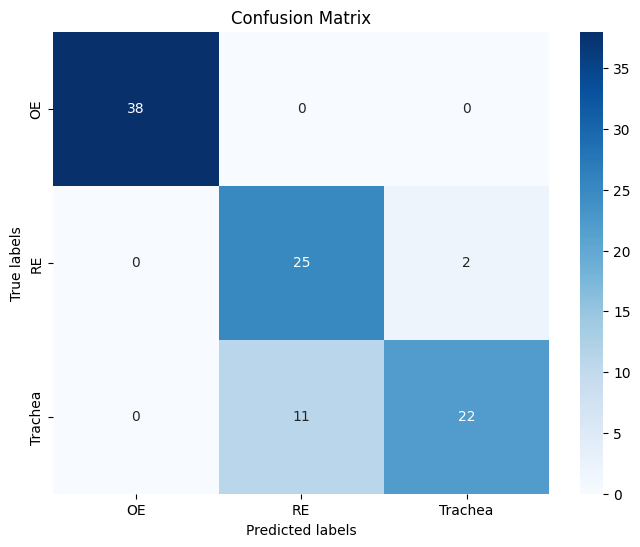

In [88]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create the heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['OE', 'RE', 'Trachea'], 
            yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [89]:
# Perform 10-fold cross-validation
scores = cross_val_score(model, X, y, cv=10)

# Calculate the average and standard deviation of the scores, rounded to 2 decimal places
average_score = np.mean(scores)
std_deviation = np.std(scores)

# Print the results, rounded to 2 decimal places
print("Cross-validation scores:", scores)
print("Average score:", f"{average_score:.2f}")
print("Standard deviation of scores:", f"{std_deviation:.2f}")

Cross-validation scores: [0.91836735 0.83673469 0.87755102 0.89795918 0.87755102 0.79591837
 0.89795918 0.87755102 0.83673469 0.875     ]
Average score: 0.87
Standard deviation of scores: 0.03


In [90]:
# Predict probabilities for each class
y_probs = model.predict_proba(X_test)

# Binarize the test labels
class_names = ['OE', 'RE', 'Trachea']
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Calculate "residuals" for each class
residuals = [y_test_binarized[:, i] - y_probs[:, i] for i in range(n_classes)]

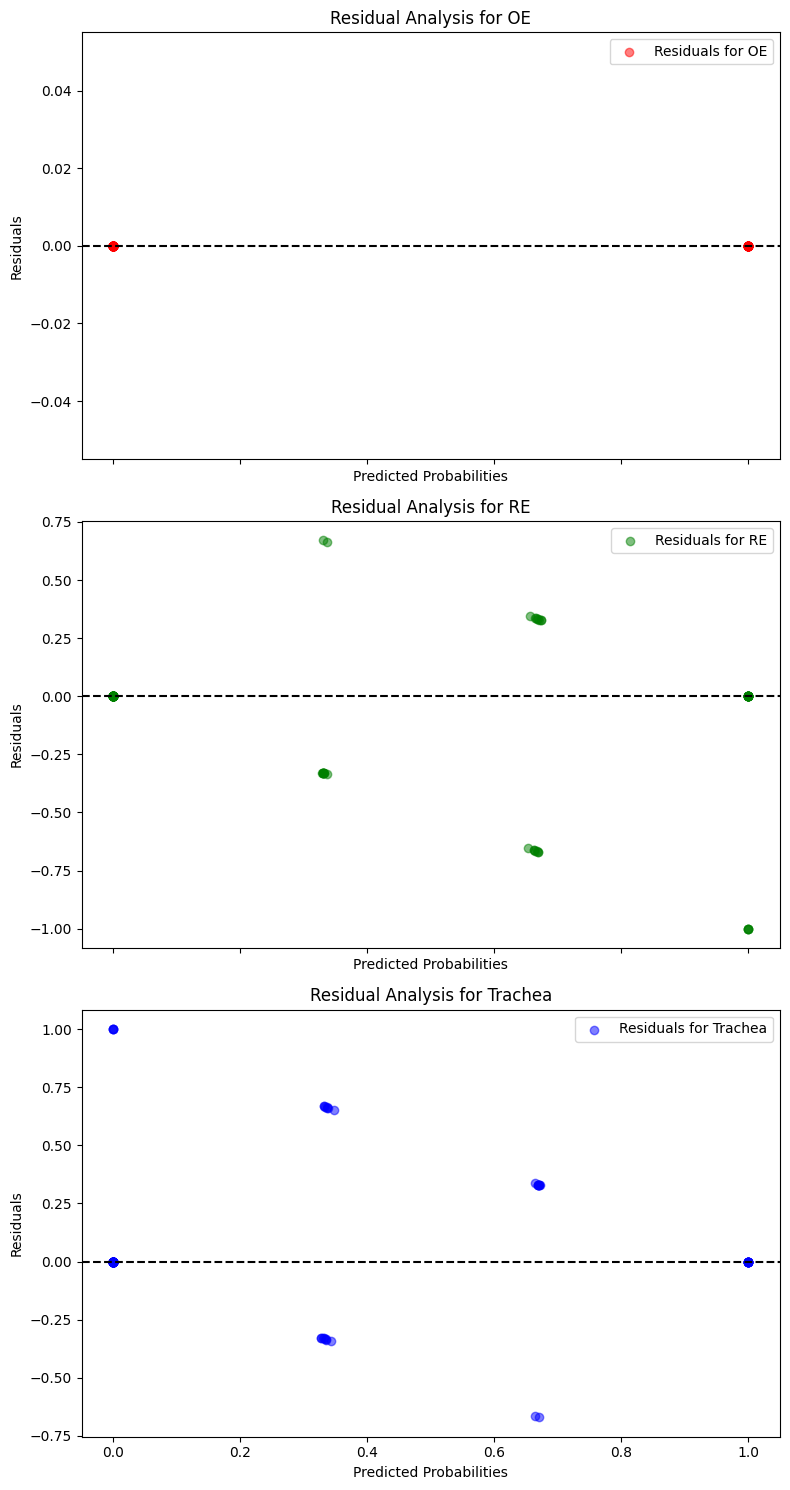

In [91]:
# Set up the subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 15), sharex=True)

colors = ['red', 'green', 'blue']
labels = ['OE', 'RE', 'Trachea']

# Plot residuals for each class on a separate subplot
for i, ax in enumerate(axes):
    ax.scatter(y_probs[:, i], residuals[i], alpha=0.5, c=colors[i], label=f'Residuals for {labels[i]}')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xlabel('Predicted Probabilities')
    ax.set_ylabel('Residuals')
    ax.set_title(f'Residual Analysis for {labels[i]}')
    ax.legend()

plt.tight_layout()
plt.show()

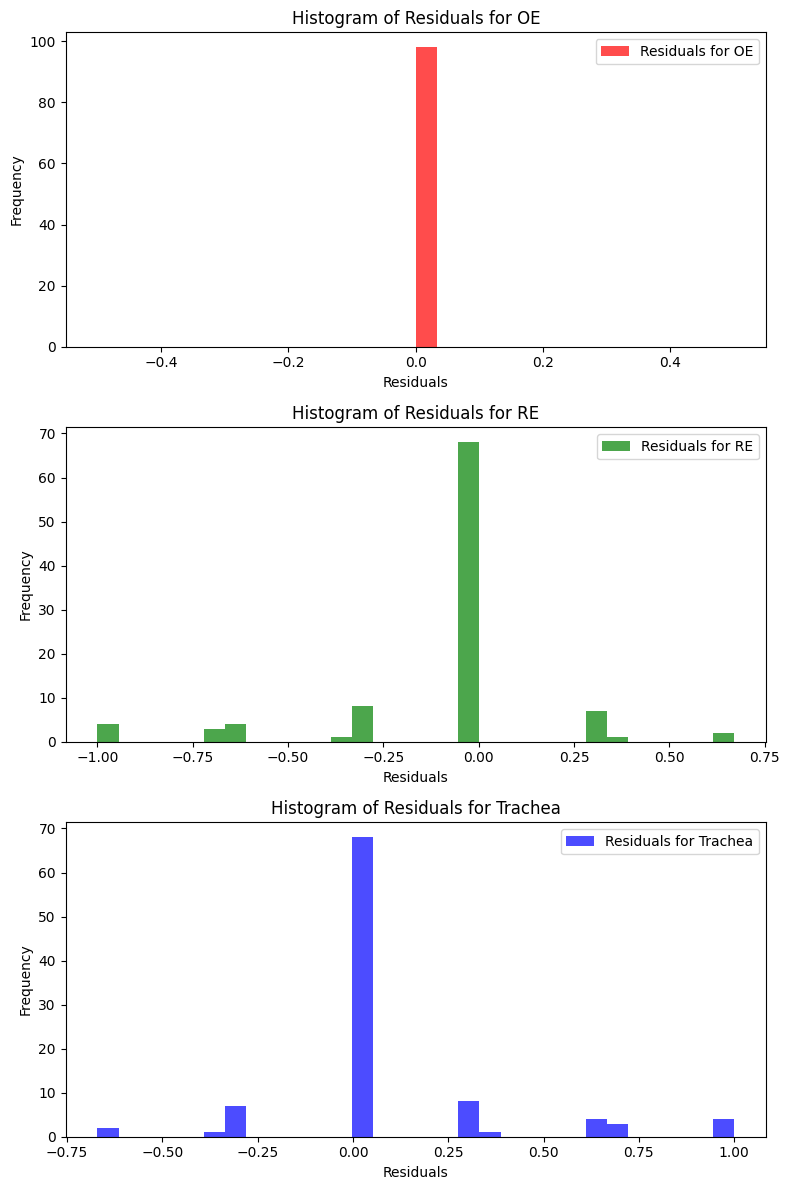

In [92]:
# Set up the subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

colors = ['red', 'green', 'blue']
labels = ['OE', 'RE', 'Trachea']

# Plot histograms of residuals for each class
for i, ax in enumerate(axes):
    ax.hist(residuals[i], bins=30, color=colors[i], alpha=0.7, label=f'Residuals for {labels[i]}')
    ax.set_title(f'Histogram of Residuals for {labels[i]}')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

In [93]:
from scipy.stats import shapiro

# Applying the Shapiro-Wilk test to each class's residuals
normality_results = {}
for i, name in enumerate(class_names):
    stat, p_value = shapiro(residuals[i])
    normality_results[name] = {'Statistic': stat, 'p-value': p_value}

# Print the results for each class
for class_name, results in normality_results.items():
    print(f"Normality Test for {class_name}: Statistic={results['Statistic']:.3f}, p-value={results['p-value']:.3f}")

Normality Test for OE: Statistic=1.000, p-value=1.000
Normality Test for RE: Statistic=0.732, p-value=0.000
Normality Test for Trachea: Statistic=0.732, p-value=0.000


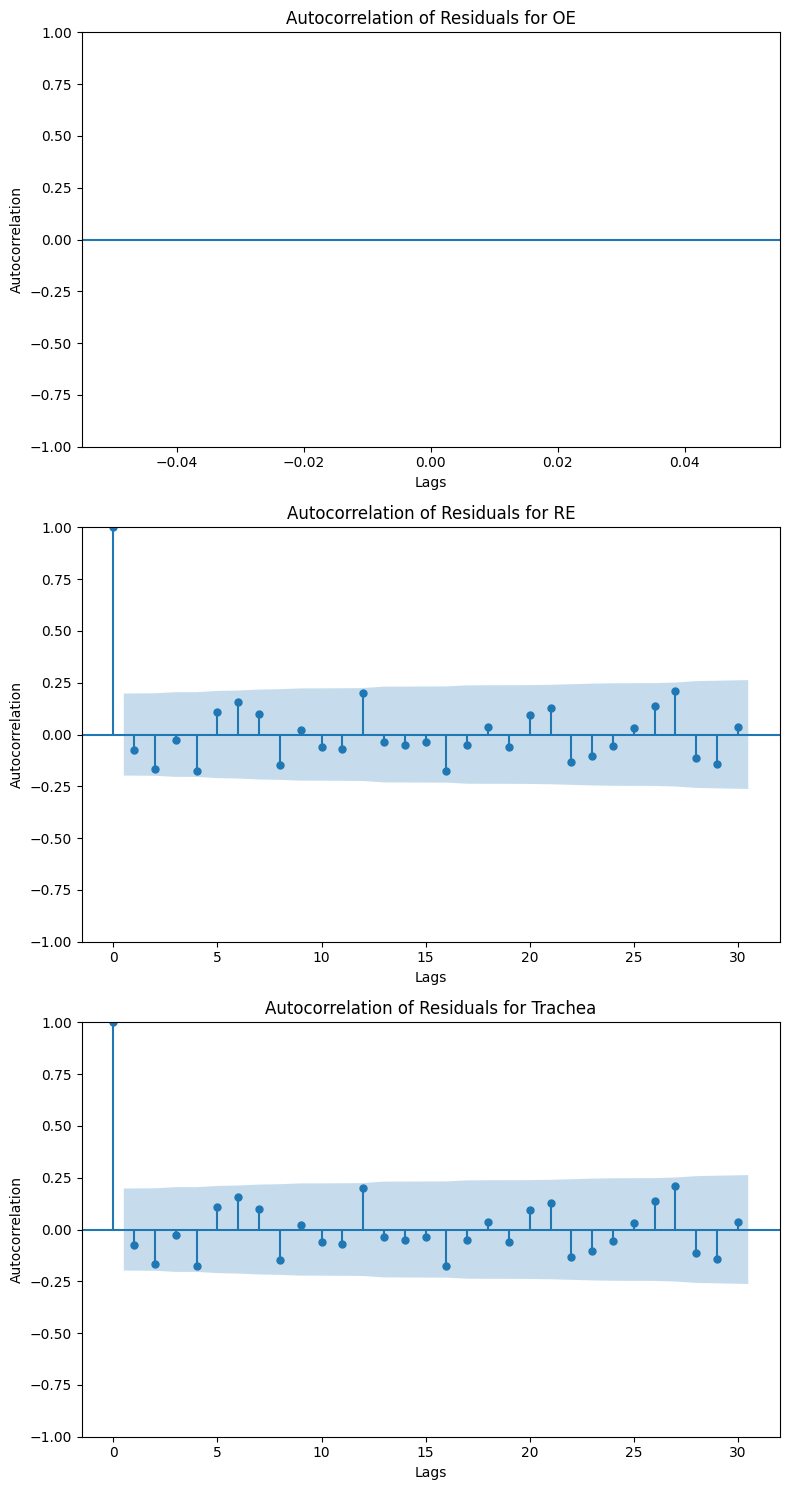

In [94]:
from statsmodels.graphics.tsaplots import plot_acf

# Example of plotting autocorrelation for the residuals of the first class
# Ensure that residuals are calculated as `y_test_binarized - y_probs` where y_probs are the predicted probabilities

fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # Adjust subplot layout

# Plot autocorrelation for each class's residuals
for i, ax in enumerate(axes.flatten()):
    plot_acf(residuals[i], ax=ax, lags=30, alpha=0.05, title=f'Autocorrelation of Residuals for {class_names[i]}')
    ax.set_xlabel('Lags')
    ax.set_ylabel('Autocorrelation')
    ax.set_title(f'Autocorrelation of Residuals for {class_names[i]}')

plt.tight_layout()
plt.show()

In [95]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

In [96]:
#wavenumber_range = np.linspace(400, 5000, 4601)
#wavenumber_range = np.linspace(900, 1800, 901)


In [97]:
# Define the combined wavenumber range
wavenumber_range_1 = np.linspace(3000, 2800, 201)
wavenumber_range_2 = np.linspace(1800, 900, 901)
wavenumber_range = np.concatenate((wavenumber_range_1, wavenumber_range_2))

In [98]:
# Perform permutation feature importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Get the importance of each feature
feature_importance = result.importances_mean

In [99]:
# Supposons que vous avez les importances stockées dans une variable `feature_importance`
#for index, importance in enumerate(feature_importance):
    #print(f"Wavenumber {wavenumber_range[index]}: Importance = {importance}")


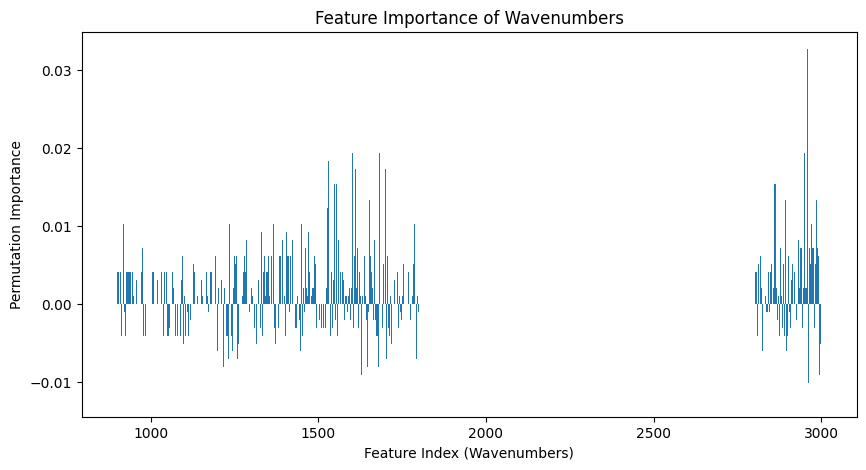

In [100]:

plt.figure(figsize=(10, 5))
plt.bar(wavenumber_range, feature_importance, width=1.0)
plt.xlabel('Feature Index (Wavenumbers)')
plt.ylabel('Permutation Importance')
plt.title('Feature Importance of Wavenumbers')
plt.show()

Top 10 Important Wavenumbers:
Wavenumber 2959 (Index 41): Importance = 0.0327
Wavenumber 1646 (Index 355): Importance = 0.0286
Wavenumber 2979 (Index 21): Importance = 0.0245
Wavenumber 2988 (Index 12): Importance = 0.0194
Wavenumber 1602 (Index 399): Importance = 0.0194
Wavenumber 2950 (Index 50): Importance = 0.0194
Wavenumber 1683 (Index 318): Importance = 0.0194
Wavenumber 1531 (Index 470): Importance = 0.0184
Wavenumber 1627 (Index 374): Importance = 0.0173
Wavenumber 1615 (Index 386): Importance = 0.0173


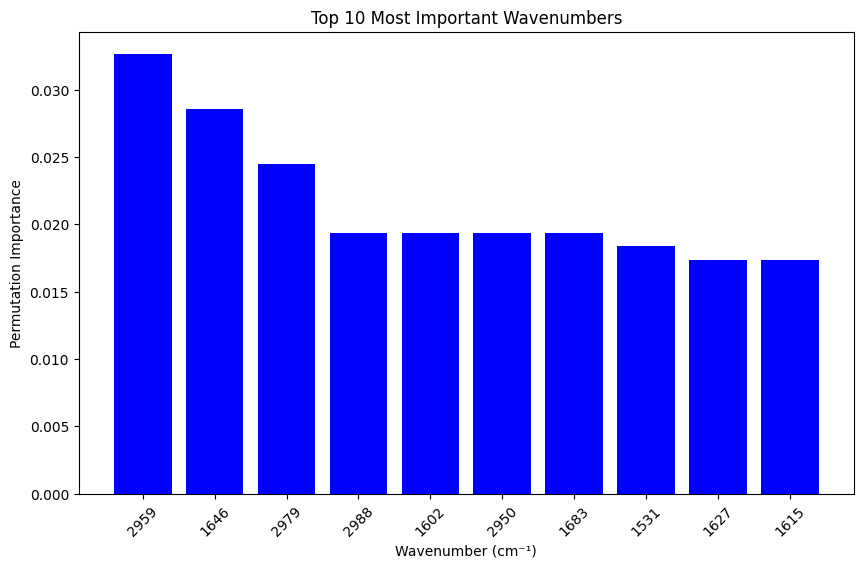

In [101]:

# Sort the features by importance
sorted_idx = np.argsort(feature_importance)[::-1]  # Descending order

# Get the indices of the top 10 features
top_10_indices = sorted_idx[:10]

# Print the top 10 important wavenumbers and their importance values
print("Top 10 Important Wavenumbers:")
top_10_wavenumbers = wavenumber_range[top_10_indices]
for idx, wavenumber in zip(top_10_indices, top_10_wavenumbers):
    print(f"Wavenumber {int(wavenumber)} (Index {idx}): Importance = {feature_importance[idx]:.4f}")

# Plotting the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(10), feature_importance[top_10_indices], color='blue', align='center')
plt.xticks(range(10), [f'{int(wavenumber)}' for wavenumber in top_10_wavenumbers], rotation=45)
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Permutation Importance')
plt.title('Top 10 Most Important Wavenumbers')
plt.show()

Group 0 Importance Cluster: Wavenumbers [0, 1, 2, 3, 5, 6, 9, 16, 19, 20, 24, 25, 31, 37, 38, 42, 43, 48, 49, 55, 56, 57, 58, 63, 72, 74, 75, 82, 84, 85, 90, 92, 94, 101, 104, 105, 106, 110, 111, 115, 116, 125, 126, 130, 143, 144, 150, 152, 153, 155, 162, 164, 170, 175, 186, 190, 194, 207, 208, 215, 221, 224, 225, 226, 227, 253, 254, 258, 260, 261, 262, 263, 275, 278, 283, 284, 289, 290, 291, 292, 293, 296, 297, 302, 304, 309, 316, 317, 321, 324, 325, 327, 328, 330, 336, 337, 346, 354, 356, 357, 364, 365, 371, 372, 379, 381, 382, 395, 396, 400, 405, 406, 412, 423, 424, 431, 436, 444, 445, 446, 448, 449, 450, 459, 464, 479, 483, 485, 490, 491, 497, 498, 505, 506, 516, 522, 525, 541, 543, 548, 550, 553, 554, 557, 566, 569, 574, 582, 589, 599, 618, 620, 628, 631, 635, 659, 666, 667, 668, 672, 673, 678, 685, 691, 702, 714, 716, 726, 739, 741, 742, 746, 752, 753, 755, 757, 759, 760, 762, 764, 769, 770, 772, 773, 774, 775, 776, 777, 784, 801, 809, 829, 863, 865, 872, 878, 881, 882, 888, 897,

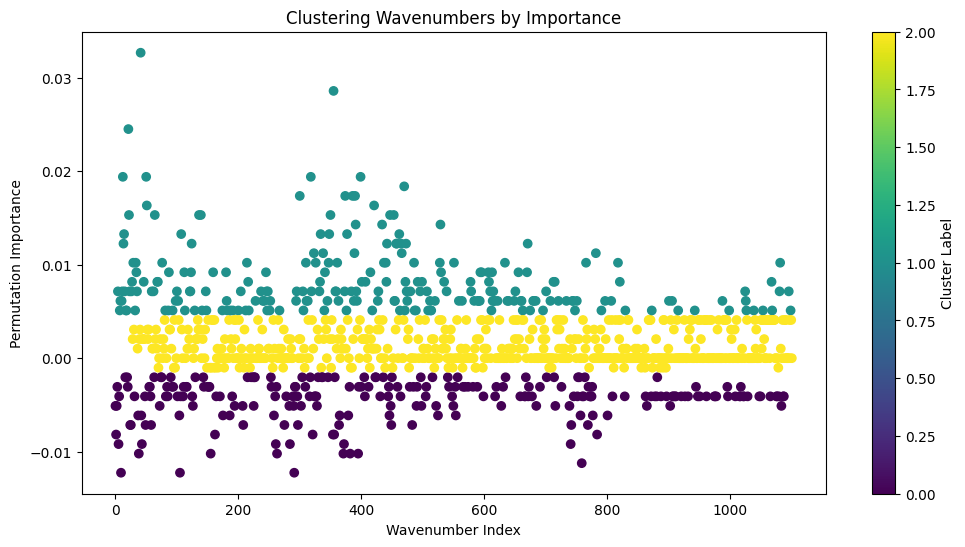

In [102]:
from sklearn.cluster import KMeans

# Number of clusters (e.g., 3 for high, medium, low importance)
n_clusters = 3

# Reshape feature_importance for clustering
importance_reshaped = feature_importance.reshape(-1, 1)

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(importance_reshaped)

# Get cluster labels
labels = kmeans.labels_

# Group wavenumbers by their cluster labels
grouped_wavenumbers = {i: [] for i in range(n_clusters)}
for i, label in enumerate(labels):
    grouped_wavenumbers[label].append(i)

# Output the grouped wavenumbers
for group, wavenumbers in grouped_wavenumbers.items():
    print(f"Group {group} Importance Cluster: Wavenumbers {wavenumbers}")

# Optionally, plot the importance with clusters marked
plt.figure(figsize=(12, 6))
plt.scatter(range(len(feature_importance)), feature_importance, c=labels, cmap='viridis')
plt.colorbar(label='Cluster Label')
plt.xlabel('Wavenumber Index')
plt.ylabel('Permutation Importance')
plt.title('Clustering Wavenumbers by Importance')
plt.show()

In [103]:
# Vérifiez si des valeurs d'importance sont négatives
if np.any(feature_importance < 0):
    print("Des valeurs d'importance négatives ont été détectées, ce qui pourrait indiquer une erreur.")
    feature_importance = np.maximum(feature_importance, 0)  # Remplacer les valeurs négatives par 0


Des valeurs d'importance négatives ont été détectées, ce qui pourrait indiquer une erreur.


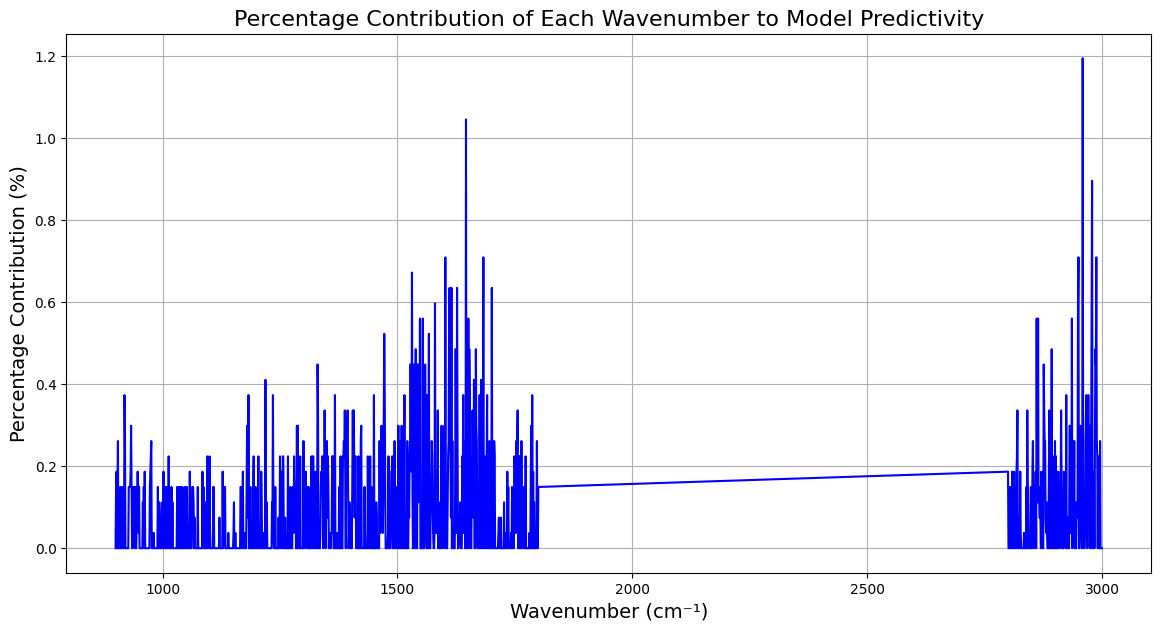

In [104]:

# Calcul de l'importance totale
total_importance = np.sum(feature_importance)

# Calcul des pourcentages de contribution pour chaque wavenumber
contribution_percentages = (feature_importance / total_importance) * 100

# Création du graphique
plt.figure(figsize=(14, 7))
plt.plot(wavenumber_range, contribution_percentages, marker='', linestyle='-', color='blue')
plt.xlabel('Wavenumber (cm⁻¹)', fontsize=14)
plt.ylabel('Percentage Contribution (%)', fontsize=14)
plt.title('Percentage Contribution of Each Wavenumber to Model Predictivity', fontsize=16)
plt.grid(True)
plt.show()

In [105]:
print(total_importance)

2.7346938775510186


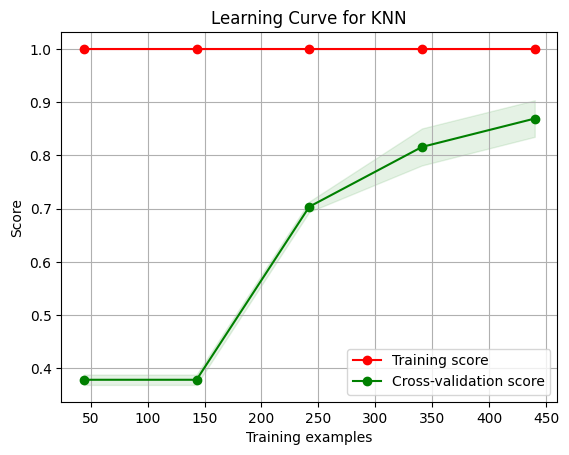

In [106]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters:
        estimator : object type that implements the "fit" and "predict" methods
        title : string, title of the chart
        X : array-like, shape (n_samples, n_features), feature matrix
        y : array-like, shape (n_samples) or (n_samples, n_features), label vector
        ylim : tuple, shape (ymin, ymax), Defines minimum and maximum y-values
        cv : int, cross-validation generator or an iterable, optional
        n_jobs : int or None, optional (default=None), Number of jobs to run in parallel
        train_sizes : array-like, shape (n_ticks,), relative or absolute numbers of training examples that will be used to generate the learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Call the function to plot the learning curve
plot_learning_curve(model, 'Learning Curve for KNN', X, y, cv=10)
plt.show()

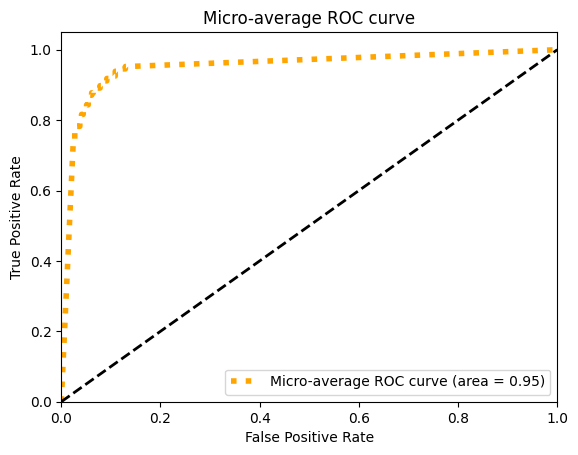

In [107]:
# Assuming X and y are already defined
# Binarize the output
y_roc = label_binarize(y, classes=[0, 1, 2])
n_classes = y_roc.shape[1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_roc, test_size=0.3, random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(model)
classifier.fit(X_train, y_train)

# Predict probabilities for the test data
y_score = classifier.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the micro-average ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='orange', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC curve')
plt.legend(loc="lower right")
plt.show()

In [108]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro"
)

print(f"Macro-averaged One-vs-Rest ROC AUC score: {macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score: 0.94


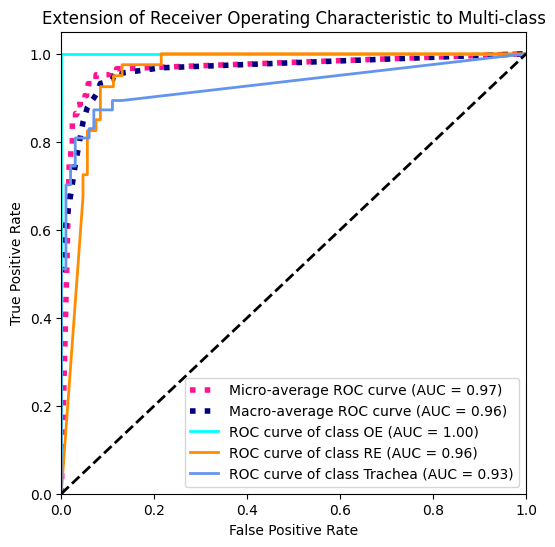

In [109]:
# S'assurer que y_score est obtenue par predict_proba
y_score = model.predict_proba(X_test)

# Binarisation des étiquettes
class_names = ['OE', 'RE', 'Trachea']
y_onehot_test = label_binarize(y_test, classes=range(len(class_names)))
n_classes = y_onehot_test.shape[1]

# Calcul des courbes ROC et des aires AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcul de la moyenne micro
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calcul de la moyenne macro
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.mean([np.interp(all_fpr, fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Tracé des courbes ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to Multi-class')
plt.legend(loc="lower right")
plt.show()